<a href="https://colab.research.google.com/github/IT24102008/PG151MLProject/blob/main/notebooks/group_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Missing values before: 201
Missing values after: 0


/tmp/ipython-input-959543516.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['bmi'].fillna(df['bmi'].median(), inplace=True)


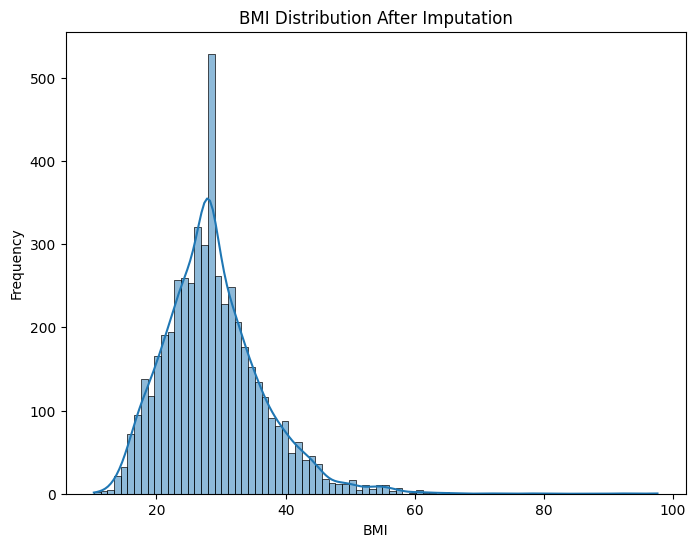

Group Interpretation: Median imputation (28.1) preserves bmi distribution, reducing bias in stroke class.
Selected Features: ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'ever_married_Yes', 'work_type_Self-employed', 'work_type_children', 'Residence_type_Urban', 'smoking_status_formerly smoked']
Final dataset saved as stroke_processed_pca.csv
Training and testing sets saved.


In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Ensure directories exist
os.makedirs('/content/results/eda_visualizations', exist_ok=True)
os.makedirs('/content/results/outputs', exist_ok=True)


# Load data
df = pd.read_csv('/content/drive/MyDrive/PG151MLProject/data/raw/StrokeData.csv')

# Group: Handle Missing Data
# Group decision: Median imputation for bmi skewness
print("Missing values before:", df['bmi'].isnull().sum())
df['bmi'].fillna(df['bmi'].median(), inplace=True)
print("Missing values after:", df['bmi'].isnull().sum())

# EDA: Group-level histogram for bmi
plt.figure(figsize=(8, 6))
sns.histplot(df['bmi'], kde=True)
plt.title('BMI Distribution After Imputation')
plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.savefig('/content/results/eda_visualizations/bmi_distribution.png')
plt.show()
print("Group Interpretation: Median imputation (28.1) preserves bmi distribution, reducing bias in stroke class.")

# Member 4: Encoding Categorical Variables
# Member 4 - Withana W.Y.P
categorical_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Member 5: Outlier Removal
# Member 5 - De Silva P.K.N
def cap_outliers(df, cols=['avg_glucose_level', 'bmi']):
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        df[col] = df[col].clip(Q1 - 1.5 * IQR, Q3 + 1.5 * IQR)
    return df
df = cap_outliers(df)

# Member 6: Normalization/Scaling
# Member 6 - Inshaf M J M
scaler = StandardScaler()
numerical_cols = ['age', 'avg_glucose_level', 'bmi']
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# Member 1: Feature Engineering - Binning (Removing for simplicity)
# df['age_bin'] = pd.cut(df['age'], bins=[0, 30, 60, 82], labels=['0-30', '31-60', '61+'])
# df['glucose_bin'] = pd.qcut(df['avg_glucose_level'], q=4, labels=['Low', 'Medium', 'High', 'Very High'])

# Member 3: Feature Selection
# Member 3 - Pihara H.G.T
X = df.drop(['stroke', 'id'], axis=1)
y = df['stroke']

# SelectKBest with chi2 is only suitable for non-negative features,
# and after scaling, features can be negative.
# Let's use f_classif which works with both positive and negative features.
from sklearn.feature_selection import f_classif
selector = SelectKBest(f_classif, k=10) # Adjusted k to 10

# Fit and transform
X_selected = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()].tolist()
print("Selected Features:", selected_features)


# Member 2: Dimension Reduction (PCA)
# Member 2 - Kuruppuarachchige K.A.H.B

# PCA should be applied after one-hot encoding.
# The selected features from SelectKBest will be used for PCA.

pca = PCA(n_components=5) # Adjust based on variance analysis, reducing to 5 for now
X_pca_reduced = pca.fit_transform(X_selected)


# Final DataFrame
df_final = pd.DataFrame(X_pca_reduced, columns=[f'PC{i+1}' for i in range(X_pca_reduced.shape[1])])
df_final['stroke'] = y.reset_index(drop=True)

# Save final dataset
df_final.to_csv('/content/results/outputs/stroke_processed_pca.csv', index=False)
print("Final dataset saved as stroke_processed_pca.csv")

# Split for model training (optional for demo)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_final.drop('stroke', axis=1), df_final['stroke'], test_size=0.2, random_state=42, stratify=df_final['stroke'])
X_train.to_csv('/content/results/outputs/X_train.csv', index=True)
y_train.to_csv('/content/results/outputs/y_train.csv', index=True)
X_test.to_csv('/content/results/outputs/X_test.csv', index=True)
y_test.to_csv('/content/results/outputs/y_test.csv', index=True)
print("Training and testing sets saved.")

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
